In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from rhessys import utilities as rh
import hydro.objective_fxns as ofx
import ntpath
from hydro import objective_fxns as ob
from IPython.display import clear_output
import ipyparallel as p
import ProgressBar as pb
from pymail import alert
import time
import matplotlib.dates as mdates

In [2]:
titlefont = 18
axfont = 14
tickfont = 12
lw = 3

simcolET = 'lime'
simcolQ = 'deepskyblue'
obscol = 'k'
diffcol = 'k'
diffstyle = '--'
diffwt = 2
midcol = '0.5'
midstyle = '-'
midwt = 2

In [3]:
import seaborn as sns
sns.set_style(style='white')

import matplotlib.dates as mdates

In [4]:
ca = pd.read_pickle('./data/p301_ET_opt1_15047_NSE0_29.pcl')
co = pd.read_pickle('./data/afx_ET_opt1_24320_NSE0_32.pcl')

In [5]:
ca['site'] = 'CA'
co['site'] = 'CO'

In [6]:
df = pd.concat([co,ca])

In [7]:
df['datetime'] = df.index

In [8]:
f.axes[0]

NameError: name 'f' is not defined

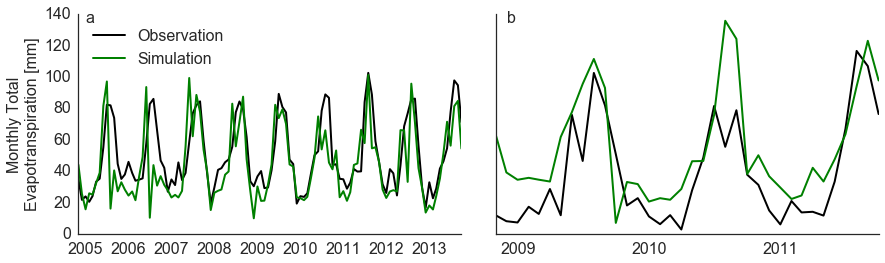

In [25]:
years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')

g = sns.FacetGrid(df,col='site',sharex=False,aspect=1.5,size=4)
h = g.map(plt.plot,'datetime','Observations',c='k',lw=2,label = 'Observation')
f = g.map(plt.plot,'datetime','Simulation',c='g',lw=2, label = 'Simulation')
ax1 = f.axes[0][0]
ax2 = f.axes[0][1]
#ax1.set_title('a: CO - NSE: 0.32', fontsize = 16)
#ax2.set_title('b: CA - NSE: 0.29', fontsize = 16)
ax1.text('2005',135,'a',fontsize=16)
ax1.set_title('')
ax2.text('2008-12',135,'b',fontsize=16)
ax2.set_title('')

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)

for ax in [ax1,ax2]:
    [tick.label.set_fontsize(16) for tick in ax.yaxis.get_major_ticks()];
    [tick.label.set_fontsize(16) for tick in ax.xaxis.get_major_ticks()];
    ax.set_xlabel('')
    ax.set_ylabel('')

ax1.legend(fontsize=16,loc='upper left')
ax1.set_ylabel('Monthly Total\nEvapotranspiration [mm]', fontsize=16)
plt.savefig('./figures/calibration_v2.png',dpi=300,bbox_inches='tight')
plt.savefig('./figures/calibration_v2.pdf',bbox_inches='tight')

## Vcm

In [19]:
calname = 'et_cal57'
site = 'jemez'
strt = 2010
nd = 2010
title = 'c: NM'

FT = pd.read_pickle('../%s/data/VCM_2.pcl'%(site))
FT['wateryear'] = FT.index.map(rh.wateryear)
FT_daily = FT.loc[(FT.wateryear>=strt) & (FT.wateryear<=nd),:]
FT_weekly = FT_daily.resample('W').apply(np.sum)
FT_monthly = FT_daily.resample('M').apply(np.sum)

Q = pd.read_pickle('../%s/data/lower_lajara_specific_discharge.pcl'%site)
Q['wateryear'] = Q.index.map(rh.wateryear)
Q_daily = Q.loc[(Q.wateryear>=strt) & (Q.wateryear<=nd),:]
Q_weekly = Q_daily.resample('W').apply(np.sum)
Q_monthly = Q_daily.resample('M').apply(np.sum)

df = pd.read_pickle('../%s/data/%s.pcl'%(site,calname))

idx = df.loc[df.monthly == df.monthly.max()].idx.as_matrix()[0]

dat = rh.readRHESSysBasin('/RHESSys/%s/out/%s/%s_%s_basin.daily'%(site,calname,calname,idx))
dat_daily = dat.loc[(dat.wateryear>=strt) & (dat.wateryear <=nd)]
dat_monthly = dat_daily.resample('M').apply(np.sum)

dat_monthly['diff_ET'] = FT_monthly.ET-dat_monthly.ET
dat_monthly['diff_Q'] = Q_monthly.discharge - dat_monthly.streamflow

In [21]:
#months = MonthLocator(range(1, 13), bymonthday=1, interval=3)
months = mdates.MonthLocator(range(1, 13), bymonthday=1, interval=4)  # every month
monthsFMT = mdates.DateFormatter('%m/%y')

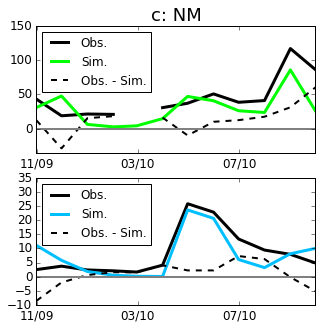

In [36]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax1.plot(FT_monthly.ET,'-',c=obscol,lw=lw,label = 'Obs.')
ax1.plot(dat_monthly.ET,'-',c=simcolET,lw=lw, label = 'Sim.')
ax1.plot(dat_monthly.diff_ET,diffstyle,c=diffcol,lw=diffwt,label= 'Obs. - Sim.')
ax1.axhline(0,c=midcol,ls=midstyle,lw=midwt)
#ax1.set_ylabel('ET [mm]',fontsize=axfont)
ax1.set_title(title,fontsize=titlefont)
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFMT)
ax1.set_ylim(-35,150)
[tick.label.set_fontsize(tickfont) for tick in ax1.xaxis.get_major_ticks()];
[tick.label.set_fontsize(tickfont) for tick in ax1.yaxis.get_major_ticks()];

ax1.legend(loc='upper left')

ax2 = fig.add_subplot(212)
ax2.plot(Q_monthly.discharge, '-',c=obscol,lw=lw, label = 'Obs.')
ax2.plot(dat_monthly.streamflow,'-',c=simcolQ,lw=lw, label = 'Sim.')
ax2.plot(dat_monthly.diff_Q,diffstyle,c=diffcol,lw=diffwt,label= 'Obs. - Sim.')
ax2.axhline(0,c=midcol,ls=midstyle,lw=midwt)
#ax2.set_ylabel('Q [mm]',fontsize=axfont)
ax2.set_ylim(-10,35)
ax2.legend(loc='upper left')
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(monthsFMT)


[tick.label.set_fontsize(tickfont) for tick in ax2.xaxis.get_major_ticks()];
[tick.label.set_fontsize(tickfont) for tick in ax2.yaxis.get_major_ticks()];

plt.savefig('./figures/%s_calibration_%s.pdf'%(title,idx),bbox_inches='tight')

## P301

In [40]:
calname = 'et_cal17'
site = 'providence'
strt = 2009
nd = 2010
title = 'b: CA'

In [41]:
FT = pd.read_pickle('../../../greenness_timing/ameriflux/CA_p301/P301.pcl')
FT['ET'] = FT.tot_ET
FT['wateryear'] = FT.index.map(rh.wateryear)
FT_daily = FT.loc[(FT.wateryear>=strt) & (FT.wateryear<=nd),:]
FT_weekly = FT_daily.resample('W',how=np.sum)
FT_monthly = FT_daily.resample('M',how=np.sum)

Q = pd.read_pickle('../%s/data/P301_specific_discharge.pcl'%(site))
Q['wateryear'] = Q.index.map(rh.wateryear)
Q_daily = Q.loc[(Q.wateryear>=strt) & (Q.wateryear<=nd),:]
Q_weekly = Q_daily.resample('W',how=np.sum)
Q_monthly = Q_daily.resample('M',how=np.sum)

df = pd.read_pickle('../%s/data/%s.pcl'%(site,calname))

idx = df.loc[df.monthly == df.monthly.max()].idx.as_matrix()[0]

dat = rh.readRHESSysBasin('/RHESSys/%s/theo_p301_flux/out/%s/%s_%s_basin.daily'%(site,calname,calname,idx))
dat_daily = dat.loc[(dat.wateryear>=strt) & (dat.wateryear <=nd)]
dat_monthly = dat_daily.resample('M').sum()

dat_monthly['diff_ET'] = FT_monthly.ET-dat_monthly.ET
dat_monthly['diff_Q'] = Q_monthly.discharge - dat_monthly.streamflow

/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


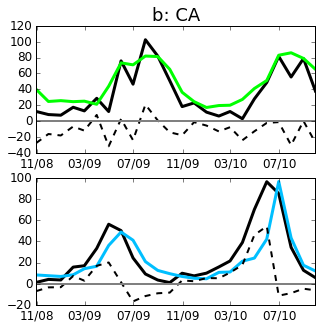

In [45]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax1.plot(FT_monthly.ET,'-',c=obscol,lw=lw,label = 'Obs.')
ax1.plot(dat_monthly.ET,'-',c=simcolET,lw=lw, label = 'Sim.')
ax1.plot(dat_monthly.diff_ET,diffstyle,c=diffcol,lw=diffwt,label= 'Obs. - Sim.')
ax1.axhline(0,c=midcol,ls=midstyle,lw=midwt)
#ax1.set_ylabel('ET [mm]',fontsize=axfont)
ax1.set_title(title,fontsize=titlefont)
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFMT)
#ax1.set_ylim(-35,150)
[tick.label.set_fontsize(tickfont) for tick in ax1.xaxis.get_major_ticks()];
[tick.label.set_fontsize(tickfont) for tick in ax1.yaxis.get_major_ticks()];

#ax1.legend(loc='upper left')

ax2 = fig.add_subplot(212)
ax2.plot(Q_monthly.discharge, '-',c=obscol,lw=lw, label = 'Obs.')
ax2.plot(dat_monthly.streamflow,'-',c=simcolQ,lw=lw, label = 'Sim.')
ax2.plot(dat_monthly.diff_Q,diffstyle,c=diffcol,lw=diffwt,label= 'Obs. - Sim.')
ax2.axhline(0,c=midcol,ls=midstyle,lw=midwt)
#ax2.set_ylabel('Q [mm]',fontsize=axfont)
#ax2.set_ylim(-10,35)
#ax2.legend(loc='upper left')
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(monthsFMT)


[tick.label.set_fontsize(tickfont) for tick in ax2.xaxis.get_major_ticks()];
[tick.label.set_fontsize(tickfont) for tick in ax2.yaxis.get_major_ticks()];

plt.savefig('./figures/%s_calibration_%s.pdf'%(title,idx),bbox_inches='tight')

## Nr1

In [3]:
calname = 'et_cal29'
site = 'ComoCreek_new'
strt = 2008
nd = 2012
title = 'a: CO'

In [4]:
idx

NameError: name 'idx' is not defined

In [5]:
FT = pd.read_pickle('../../greenness_timing/data/AFX2_new.pcl')
FT['wateryear'] = FT.index.map(rh.wateryear)
FT_daily = FT.loc[(FT.wateryear>=strt) & (FT.wateryear<=nd),:]
FT_yearly = FT_daily.groupby(by='wateryear').sum()
FT_weekly = FT_daily.resample('W',how=np.sum)
FT_monthly = FT_daily.resample('M',how=np.sum)

Q = pd.read_pickle('/RHESSys/Comocreek/barnhatb/obs/como_specific_discharge_daily.pcl')
Q['wateryear'] = Q.index.map(rh.wateryear)
Q_daily = Q.loc[(Q.wateryear>=strt) & (Q.wateryear<=nd),:]
Q_yearly = Q_daily.groupby(by='wateryear').sum()
Q_weekly = Q_daily.resample('W',how=np.sum)
Q_monthly = Q_daily.resample('M',how=np.sum)

df = pd.read_pickle('../data/%s.pcl'%(calname))

idx = df.loc[df.monthly == df.monthly.max()].idx.as_matrix()[0]

dat = rh.readRHESSysBasin('/RHESSys/%s/out/%s/%s_%s_basin.daily'%(site,calname,calname,idx))
dat_daily = dat.loc[(dat.wateryear>=strt) & (dat.wateryear <=nd)]
dat_monthly = dat_daily.resample('M').sum()

dat_monthly['diff_ET'] = FT_monthly.ET-dat_monthly.ET
dat_monthly['diff_Q'] = Q_monthly.discharge - dat_monthly.streamflow

/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
/Users/barnhatb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


In [7]:
df.loc[df.monthly == df.monthly.max()]

,gw1,gw2,idx,ksat,lai,m,pa,po,rd,daily,...,nse_SF_daily,nse_SF_monthly,nse_SF_weekly,pe_ET_daily,pe_ET_monthly,pe_ET_weekly,pe_SF_daily,pe_SF_monthly,pe_SF_weekly,weekly
16342,0.624,0.21,6709,133.66,0.64,12.398,0.02,0.253,3.24,-0.285098,...,-1.306848,0.693069,0.27184,0.906927,0.319883,0.493341,0.949518,0.890277,0.964016,0.254872


In [49]:
#months = MonthLocator(range(1, 13), bymonthday=1, interval=3)
months = mdates.MonthLocator(range(1, 13), bymonthday=1, interval=8)  # every month
monthsFMT = mdates.DateFormatter('%m/%y')

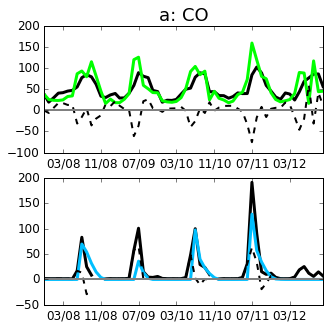

In [50]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(211)
ax1.plot(FT_monthly.ET,'-',c=obscol,lw=lw,label = 'Obs.')
ax1.plot(dat_monthly.ET,'-',c=simcolET,lw=lw, label = 'Sim.')
ax1.plot(dat_monthly.diff_ET,diffstyle,c=diffcol,lw=diffwt,label= 'Obs. - Sim.')
ax1.axhline(0,c=midcol,ls=midstyle,lw=midwt)
#ax1.set_ylabel('ET [mm]',fontsize=axfont)
ax1.set_title(title,fontsize=titlefont)
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFMT)
#ax1.set_ylim(-35,150)
[tick.label.set_fontsize(tickfont) for tick in ax1.xaxis.get_major_ticks()];
[tick.label.set_fontsize(tickfont) for tick in ax1.yaxis.get_major_ticks()];

#ax1.legend(loc='upper left')

ax2 = fig.add_subplot(212)
ax2.plot(Q_monthly.discharge, '-',c=obscol,lw=lw, label = 'Obs.')
ax2.plot(dat_monthly.streamflow,'-',c=simcolQ,lw=lw, label = 'Sim.')
ax2.plot(dat_monthly.diff_Q,diffstyle,c=diffcol,lw=diffwt,label= 'Obs. - Sim.')
ax2.axhline(0,c=midcol,ls=midstyle,lw=midwt)
#ax2.set_ylabel('Q [mm]',fontsize=axfont)
#ax2.set_ylim(-10,35)
#ax2.legend(loc='upper left')
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(monthsFMT)


[tick.label.set_fontsize(tickfont) for tick in ax2.xaxis.get_major_ticks()];
[tick.label.set_fontsize(tickfont) for tick in ax2.yaxis.get_major_ticks()];

plt.savefig('./figures/%s_calibration_%s.pdf'%(title,idx),bbox_inches='tight')